The goal of this analysis is to evaulate the pay differences between pitchers and fielders. That is to investigate on average which type of player is more valued by a team.

In [279]:
#import libraries & packages
import numpy as np
import pandas as pd
import mysql.connector as sql
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

In [280]:
#Connect to Lehmans Database
db_connection = sql.connect(host='localhost', database='Lehmans2014', 
user='root', password='XXXXXXXXXX') #password censored

The following function evaulates the validity of the hypothesis. In this test, the null hypothesis or the hypothesis we seek to reject is that on average pitchers & non-pitchers are paid the same. That is there is no average difference in pay between the two. 

H0: (average pitcher salary)-(average non-pitcher salary)==0

H1: (average pitcher salary)-(average non-pitcher salary)<>0

In [281]:
#Function to check whether null hypothesis can be rejected
def H0_validity(p,level=0.001):
    print('Pvalue = ', round(p,4))
    if p<level:
        print('Reject the Null Hypothesis')
    else:
        print('Cannot Reject Null Hypothesis')

In [282]:
#Creating Table with raw player/salary info
#query to lehman's DB
query1 = """
#Selecting all data from salaries table & adding a column to identify
#if the player is a pitcher or not
SELECT s.*, IFNULL(p.pitcher,0) AS pitcher
FROM 
	Salaries s
	LEFT JOIN (
    #Joining Salaries & Pitchers table to return a 1 when a player is in
    #both the Salaries & Pitchers tables
    SELECT 
			DISTINCT(sx.playerID),1 AS pitcher
		FROM
			Pitching px
			JOIN
			Salaries sx
		ON
			sx.playerID = px.playerID) p
ON s.playerID = p.playerID;"""

#Query Lehman's DB with query1 & store in master dataframe
master = pd.read_sql(query1, con=db_connection)

print('Number of entries: ',len(percentiles))
master.head()

Number of entries:  24758


,yearID,teamID,lgID,playerID,salary,pitcher
0,1985,ATL,NL,barkele01,870000,1
1,1985,ATL,NL,bedrost01,550000,1
2,1985,ATL,NL,benedbr01,545000,0
3,1985,ATL,NL,campri01,633333,1
4,1985,ATL,NL,ceronri01,625000,1


The following plots aim to give a general idea for how the Salaries are distributed over the years.The histograms measure how many players have a salary in various ranges.

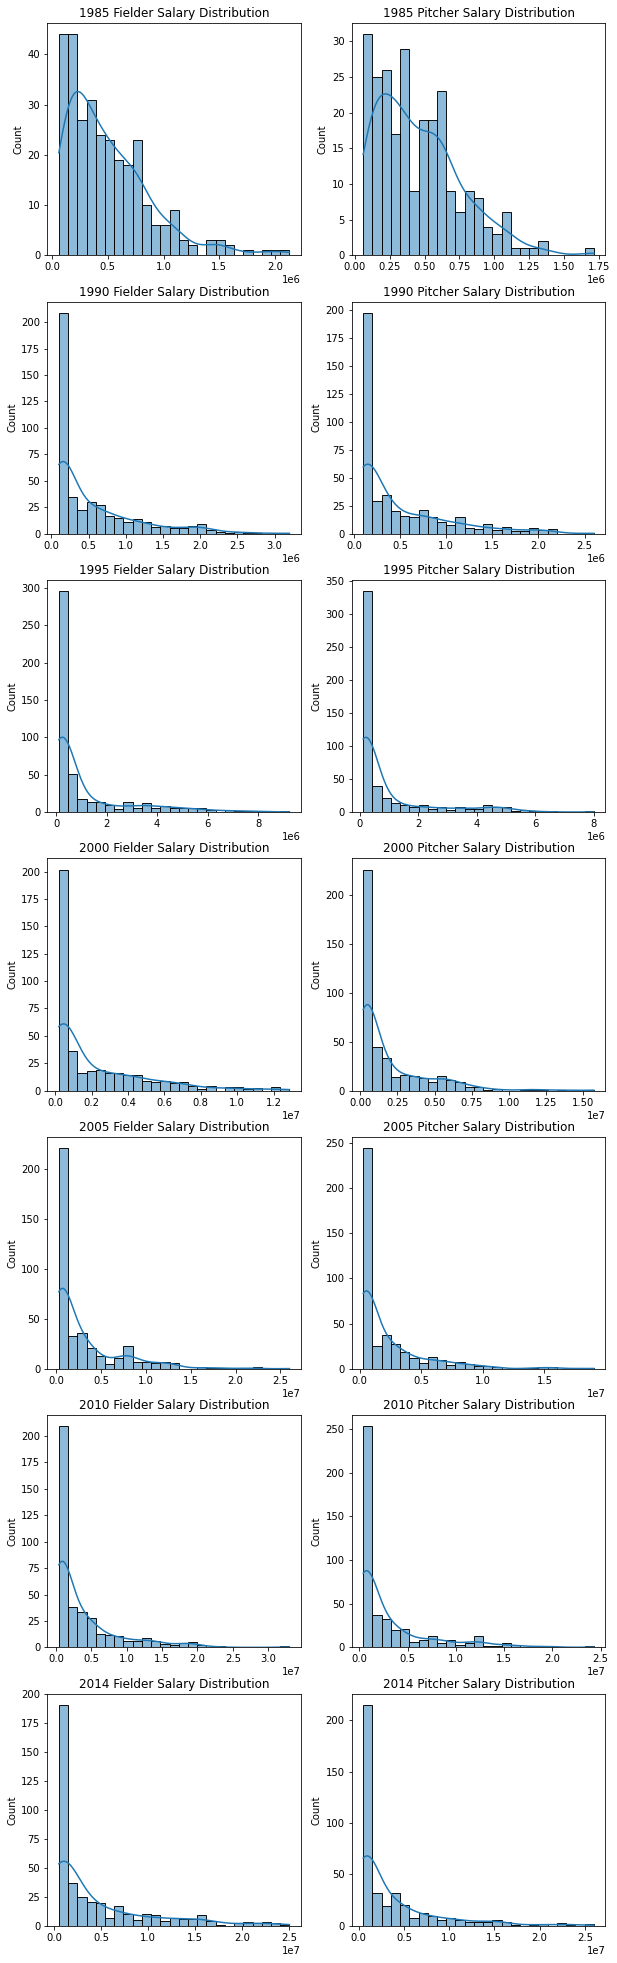

In [283]:
#Visualize Salary Data
years = [1985,1990,1995,2000,2005,2010,2014]
fig, axes = plt.subplots(7,2, figsize=(10,35))
i=0
for year in years:
    #Fielder salary
    perc_year = list(percentiles.loc[(percentiles['yearID']==year)&(percentiles['pitcher']==0),'salary'])
    sns.histplot(perc_year,ax=axes[i][0],bins=25,kde=True);
    axes[i][0].set_title(str(year)+' Fielder Salary Distribution')
    
    #Pitcher Salary
    perc_year = list(percentiles.loc[(percentiles['yearID']==year)&(percentiles['pitcher']==1),'salary'])
    sns.histplot(perc_year,ax=axes[i][1],bins=25,kde=True);
    axes[i][1].set_title(str(year)+' Pitcher Salary Distribution')
    
    #index
    i+=1

The plots above show two key insights. The first is the overall increase in salary over the years. As inflation increases, so too does the salaries. The change in the value of the dollar may skew the results of a test that only takes into account the dollar amount of each salary. The second is the dramatic growth in the disparity. That is there has been a noticeable growth in the highest salary whereas the lowest salary has not changed dramatically. This again could skew the results as we cannot fully blame inflation for increased salary values. The average salary between years will change dollar amount greatly but may not be as different as it seems.

The plots below breakdown the percentage of the total sum of salaries between pitchers and non-pitchers. The aim here is to get a feel for which group typically takes home the bigger sum of cash

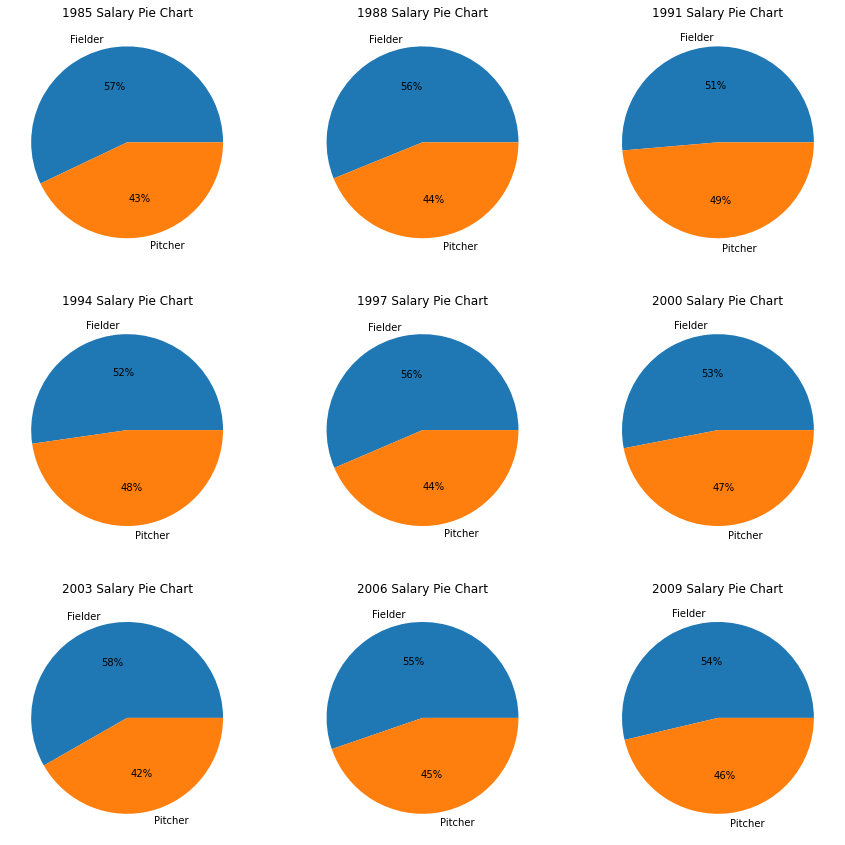

In [284]:
years = [1985,1988,1991,1994,1997,2000,2003,2006,2009]
fig, axes = plt.subplots(3,3, figsize=(15,15))

for i in range(3):
    for j in range(3):
        #Create sum array
        sum_year = []
        #Fielder salary sum
        sum_year.append(percentiles.where((percentiles.yearID==years[3*i+j])&(percentiles.pitcher==0)).salary.sum())

        #Pitcher salary sum
        sum_year.append(percentiles.where((percentiles.yearID==years[3*i+j])&(percentiles.pitcher==1)).salary.sum())

        axes[i][j].pie(sum_year, labels=['Fielder','Pitcher'], autopct='%.0f%%')
        axes[i][j].set_title(str(years[3*i+j])+' Salary Pie Chart')

Based on this quick snapshot, it can be observed the most of the time, non-pitchers make a slight majority of the money.

Below we will test the null hypothesis. That is, we will validate whether or not we can reject the hypothesis that pitchers and non-pitchers on average share the same salary.

In [286]:
#calculate average pitching salary
pitchavg = round(np.average(master.loc[percentiles['pitcher']==1,'salary'])/1000000,
                 2)

#calculate average fielder salary
fieldavg = round(np.average(master.loc[percentiles['pitcher']==0,'salary'])/1000000,
                2)
print('Overall Average Pitcher Salary: $', pitchavg, ' million')
print('Overall Average Fielder Salary: $', fieldavg, ' million')

Average Pitcher Salary: $ 1.75  million
Average Fielder Salary: $ 2.12  million


In [287]:
#Average Non-Pitcher salary per year
avg_field = list(master.where(master.pitcher==0).groupby('yearID').salary.mean())

#Average Picther's salary per year
avg_pitch = list(master.where(master.pitcher==1).groupby('yearID').salary.mean())

#Test Hypothesis
(statistic, pvalue1) = scipy.stats.ttest_ind(avg_field,avg_pitch, equal_var=False)
H0_validity(pvalue1)

Pvalue =  0.1645
Cannot Reject Null Hypothesis


The average salaries give us an insight into why this test may have failed. The top salaries in 1985 are about the same as those average salaries. The change in the value of the dollar and the increase pay from 1985 to 2014 does not give a uniform set of data to make comparisons. A few things can be done to remedy this. The salary values could be scaled by the inflation index for each year, however, those are hard to find and calculate. Another option is to rank each salary in comparison to all other salaries for that year. Percentiles provide a uniform way to evaluate each year that is not dependent on the fluctuating value of the dollar or on the ever increasing max salary. This way, we can evaluate on average what percentile do pitchers reside vs non pitchers reside.

Below we will calculate the percentiles for each player in each year. A percentile score counts the number of salaries below the current salary and divides that by the total number of salaries. 

In [288]:
'''Calculate Percentiles'''
percentiles = master.copy()
#numerator = (# of salaries < current salary)
#denominator = (total number of salaries that year)
#percentile = numerator/denominator*100
for i in range(len(percentiles)):
    #select year
    year = percentiles.loc[i,'yearID']
    
    #select salary
    sal = percentiles.loc[i,'salary']
    
    #calculate numerator
    numerator = sum((percentiles.salary<sal)&(percentiles.yearID==year))
    
    #calculate denominator
    denominator = sum(percentiles.yearID==year)
    
    #calculate percentile
    percentiles.loc[i,'percentile'] = round(numerator/denominator*100,2)

percentiles.head()

,yearID,teamID,lgID,playerID,salary,pitcher,percentile
0,1985,ATL,NL,barkele01,870000,1,87.82
1,1985,ATL,NL,bedrost01,550000,1,63.27
2,1985,ATL,NL,benedbr01,545000,0,62.91
3,1985,ATL,NL,campri01,633333,1,72.18
4,1985,ATL,NL,ceronri01,625000,1,71.27


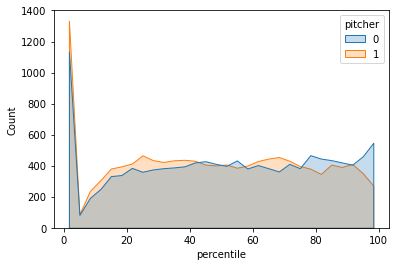

In [289]:
sns.histplot(data=percentiles,x='percentile',
            hue='pitcher', element='poly');

The above histogram again is tight. There is no definitive winner, however, the pitchers in orange seem to have a higher concentration in the lower percentiles while the non-pitchers in blue have the higher percentiles. Let's take a look at the average percentiles for each and run the test.

In [275]:
#calculate average pitching percentile
pitchavgp = round(np.average(percentiles.loc[percentiles['pitcher']==1,'percentile']),
                 2)

#calculate average fielder percentile
fieldavgp = round(np.average(percentiles.loc[percentiles['pitcher']==0,'percentile']),
                2)
print('Average Pitcher Salary Percentile: ', pitchavgp)
print('Average Fielder Salary Percentile: ', fieldavgp)

Average Pitcher Salary Percentile:  47.23
Average Fielder Salary Percentile:  50.97


In [276]:
#Average Non-Pitcher Percentile per year
avg_fieldp = list(percentiles.where(master.pitcher==0).groupby('yearID').percentile.mean())

#Average Picther's Percentile per year
avg_pitchp = list(percentiles.where(master.pitcher==1).groupby('yearID').percentile.mean())

#Test Hypothesis
(statistic, pvalue1) = scipy.stats.ttest_ind(avg_fieldp,avg_pitchp, equal_var=False)
H0_validity(pvalue1)

Pvalue =  0.0
Reject the Null Hypothesis


Our Pvalue in this test was extremely low! This provides us great confidence in rejecting the null hypothesis and concluding that on average. Non-pitchers make more than pitchers. Again, the results here can be accredited to the implementation of pay percentiles as this process greatly reduced the variability in pay between years and allowed us to evaluate the data much more uniformly.